# MNIST digit recognition with CNN

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Math
import os

import tensorflow as tf
from tensorflow import keras

## Read data

In [6]:
os.listdir('sample_data/')

['anscombe.json',
 'README.md',
 'train.csv',
 'test.csv',
 'california_housing_train.csv',
 'california_housing_test.csv',
 'mnist_train_small.csv',
 'mnist_test.csv']

In [7]:
data_path = 'sample_data/'
train_df = pd.read_csv(f'{data_path}train.csv')
test_df = pd.read_csv(f'{data_path}test.csv')

display(train_df.head(1))
display(test_df.head(1))

print(train_df.info())
print(test_df.info())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


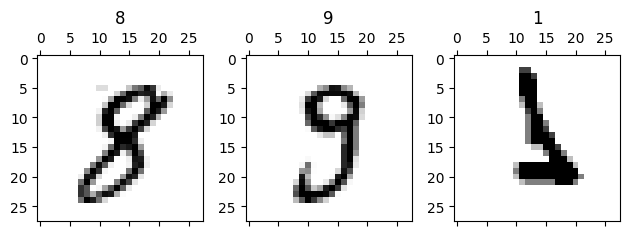

X_train shape: (33600, 28, 28, 1)
X_val shape: (8400, 28, 28, 1)
X_test shape: (28000, 28, 28, 1)

y_train shape: (33600, 10)
y_val shape: (8400, 10)


In [8]:
# Classes and dimensions
num_classes = 10 # 10 digits
img_rows, img_cols = 28, 28 # number of pixels
input_shape = (img_rows,img_cols,1)
val_set_size = .2

# X data
X_train_val = train_df.drop(columns=['label'],axis=1).values.astype('float32')
val_idx = int(X_train_val.shape[0]*(1-val_set_size))
X_train = X_train_val[:val_idx]
X_val = X_train_val[val_idx:]
X_test = test_df.values.astype('float32')

# y data
y_label_train_val = train_df['label'].values.astype('int32')
y_label_train = y_label_train_val[:val_idx]
y_label_val = y_label_train_val[val_idx:]

# Rescale X in the interval [0,1]
X_train /= 255
X_val /= 255
X_test /= 255

# Reshape X as (num_samples,**input_shape)
X_train = X_train.reshape(X_train.shape[0],*input_shape)
X_val = X_val.reshape(X_val.shape[0],*input_shape)
X_test = X_test.reshape(X_test.shape[0],*input_shape)

# Convert y entries into binary class arrays
y_train = keras.utils.to_categorical(y_label_train, num_classes)
y_val = keras.utils.to_categorical(y_label_val, num_classes)

# Plot some examples
def plt_image(ex_idx,ax):
    ex_label = y_label_train[ex_idx]
    ex_image = X_train[ex_idx]
    ax.matshow(ex_image,cmap='binary')
    ax.set_title(ex_label)

fig,axes = plt.subplots(1,3)
ex_idxs = [20,40,60]
for ex_idx,ax in zip(ex_idxs,axes):
    plt_image(ex_idx,ax)
fig.tight_layout()
plt.show()

# Print data shapes
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('')
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

## Define the CNN architecture

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


def create_CNN():
    # instantiate model
    model = Sequential()

    # Convolutional layer, pooling, dropout
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Convolutional layer, pooling, dropout
    model.add(Conv2D(20, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])

    return model

In [10]:
# training parameters
batch_size = 64
epochs = 10

# create the CNN
model_CNN = create_CNN()

# train CNN
model_history = model_CNN.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(X_val, y_val))

# evaluate model
score = model_CNN.evaluate(X_val, y_val, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.7172 - loss: 0.8495 - val_accuracy: 0.9677 - val_loss: 0.1076
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9463 - loss: 0.1693 - val_accuracy: 0.9781 - val_loss: 0.0720
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9597 - loss: 0.1245 - val_accuracy: 0.9818 - val_loss: 0.0555
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9680 - loss: 0.1082 - val_accuracy: 0.9843 - val_loss: 0.0474
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9722 - loss: 0.0864 - val_accuracy: 0.9864 - val_loss: 0.0435
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9779 - loss: 0.0733 - val_accuracy: 0.9857 - val_loss: 0.0440
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9764 - loss: 0.0696 - val_accuracy: 0.9882 - val_loss: 0.0367
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9800 - loss: 0.0629 - 

## Predict and Submit on Kaggle

In [12]:
y_labels_pred_test = model_CNN.predict(X_test) #convert back to labels
y_pred_test = np.argmax(y_labels_pred_test,axis=1)

ids = np.arange(1,len(y_pred_test)+1,dtype=int)
df_submission = pd.DataFrame({'ImageId':ids,
                              'Label':y_pred_test})
df_submission.to_csv(f"{data_path}MnistSubmissionCNNPB.csv",index=False)
df_submission.head(1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


,ImageId,Label
0,1,2


In [14]:
# Submit to kaggle
import json
import os

with open(f"{data_path}kaggle.json","rb") as f:
    credentials = json.load(f)
credentials

os.environ["KAGGLE_USERNAME"]=credentials["username"]
os.environ["KAGGLE_KEY"]=credentials["key"]

import kaggle

!kaggle competitions submit -c digit-recognizer -f sample_data/MnistSubmissionCNNPB.csv -m "MNIST digit recognition CNN"

100% 208k/208k [00:01<00:00, 108kB/s]
Successfully submitted to Digit Recognizer